In [36]:
import pandas as pd
import numpy as np
import os
import unidecode

import matplotlib.pyplot as plt
from pdpbox import pdp, info_plots, get_dataset
import shap
import seaborn as sns

from sklearn import linear_model
from scipy import stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, auc, r2_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn import metrics
import gc

import warnings
warnings.simplefilter(action='ignore')

pd.options.display.max_rows = 40
pd.set_option('display.max_columns', 200)

In [37]:
def compute_ks(y_test, y_pred_test):
    return stats.ks_2samp(y_pred_test[y_test == 1.0],y_pred_test[y_test == 0.0])[0]

## 1. Load Data

In [38]:
df = pd.read_csv("../data/interim/out6.csv")
# df = pd.read_csv("../data/interim/out6_com_outliers.csv")

In [39]:
categorical_features = ['SKProductFirstTransaction', 'Platform', 'Device', 'InstallSource','AddressState']

In [40]:
df.drop(columns = categorical_features, inplace = True)

In [41]:
df.groupby(['FlagInvitedUser', 'EVER60'])['ClientId'].count()

FlagInvitedUser  EVER60
0                0         442238
                 1          72322
1                0          74650
                 1          10028
Name: ClientId, dtype: int64

In [42]:
df_client_ids = df[['ClientId', 'M0']]

In [43]:
df.count()

ClientId                        599238
EVER60                          599238
M0                              599238
VALUE_ACCOUNT_CREDIT_INFLOW     599238
VALUE_NOT_CATEGORIZED_INFLOW    599238
                                 ...  
Renda                           599238
SALDO_CRED_DISP_M_4             599238
SALDO_CRED_DISP_M_3             599238
SALDO_CRED_DISP_M_2             599238
SALDO_CRED_DISP_M_1             599238
Length: 63, dtype: int64

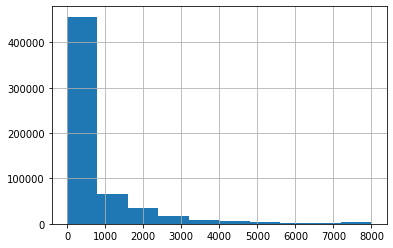

In [44]:
df['VALUE_PRODUCT_CREDIT_CARD_OUTFLOW'].hist()

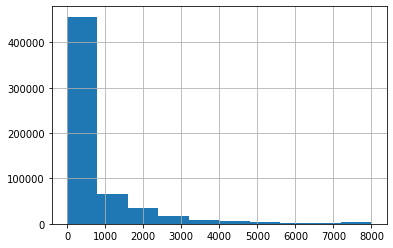

In [45]:
df['VALUE_PRODUCT_CREDIT_CARD_OUTFLOW'].hist()

In [46]:
df[['EVER60', 'ClientId', 'M0',]].to_csv('../data/interim/referencia.csv')

In [47]:
# df.columns

#### Setembro: para validacao

In [48]:
df['M0'] = pd.to_datetime(df['M0'])

In [49]:
df_validacao = df[df['M0']>='2019-09-01'].copy()
df = df[df['M0']<='2019-08-31']

In [50]:
df_validacao['M0'].max()

Timestamp('2019-09-27 00:00:00')

#### Quantidade de Clientes

In [51]:
df['ClientId'].count()

445293

#### Ajustes

In [52]:
df_ref = df[['EVER60', 'ClientId', 'M0']]
df_ref_val = df_validacao[['EVER60', 'ClientId', 'M0']]

df['target'] = df['EVER60']
df_validacao['target'] = df_validacao['EVER60']

df.drop(columns = [ 'M0', 'EVER60'], inplace = True)
df_validacao.drop(columns = [ 'M0', 'EVER60'], inplace = True)

#### Inbalanced Data

In [53]:
df['target'].value_counts()

0    384120
1     61173
Name: target, dtype: int64

## 2. Train, Test Split

In [54]:
# df.drop(columns = columns_to_drop, inplace = True)

In [55]:
X = df.drop(columns = ['target']).copy()
X_ids = df[['ClientId']]
y = df['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.3, random_state=0, shuffle = True)

X_val = df_validacao.drop(columns = ['target']).copy()
X_val.ids = df_validacao[['ClientId']]
y_val = df_validacao['target'].copy()

### Tirando do teste e da validacao os ClientIds do treinamento

In [56]:
X_test.shape

(133588, 61)

In [57]:
y_test = y_test.loc[~X_test.ClientId.isin(X_train.ClientId)]
X_test = X_test.loc[~X_test.ClientId.isin(X_train.ClientId)]

y_val = y_val.loc[~X_val.ClientId.isin(X_train.ClientId)]
X_val = X_val.loc[~X_val.ClientId.isin(X_train.ClientId)]

In [58]:
test_ids = X_test[['ClientId']]
train_ids = X_train[['ClientId']]
val_ids = X_val[['ClientId']]

In [59]:
X_test.shape, y_test.shape

((12788, 61), (12788,))

In [60]:
X_test.drop(columns = 'ClientId', inplace = True)
X_train.drop(columns = 'ClientId', inplace = True)
X_val.drop(columns = 'ClientId', inplace = True)

In [61]:
X_ids.loc[X_train.index, :].shape

(311705, 1)

In [62]:
# X1_ids.loc[y1_test.index, :].index

In [63]:
len(X_train), len(X_test), len(X_val)

(311705, 12788, 30608)

## 3. Train Model

In [64]:
import lightgbm as lgb

train_data=lgb.Dataset(X_train,label=y_train)
valid_data=lgb.Dataset(X_test,label=y_test)

params = {
        'metric' : 'auc',
        'boosting_type' : 'gbdt',
        'colsample_bytree' : 0.6,
        'num_leaves' : 15,
        'max_depth' : -1,
        'n_estimators' : 1000,
        'min_data_in_leaf':80, 
        'reg_alpha': 20,
        'reg_lambda': 20,
        #'is_unbalance':True,
        'objective':'binary',
        #'learning_rate':0.1
    }


lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=[train_data,valid_data],
                 early_stopping_rounds= 10,
                 verbose_eval= 10
                 )

Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.865836	valid_1's auc: 0.852015
[20]	training's auc: 0.874294	valid_1's auc: 0.86048
[30]	training's auc: 0.878618	valid_1's auc: 0.864848
[40]	training's auc: 0.881502	valid_1's auc: 0.867545
[50]	training's auc: 0.88346	valid_1's auc: 0.869132
[60]	training's auc: 0.885099	valid_1's auc: 0.871082
[70]	training's auc: 0.886338	valid_1's auc: 0.872053
[80]	training's auc: 0.887291	valid_1's auc: 0.872887
[90]	training's auc: 0.88817	valid_1's auc: 0.87358
[100]	training's auc: 0.888808	valid_1's auc: 0.873909
[110]	training's auc: 0.889441	valid_1's auc: 0.874321
[120]	training's auc: 0.889985	valid_1's auc: 0.874769
[130]	training's auc: 0.89042	valid_1's auc: 0.87499
[140]	training's auc: 0.890912	valid_1's auc: 0.875237
[150]	training's auc: 0.891318	valid_1's auc: 0.875369
[160]	training's auc: 0.891741	valid_1's auc: 0.875739
[170]	training's auc: 0.892089	valid_1's auc: 0.875946
[180]	training's au

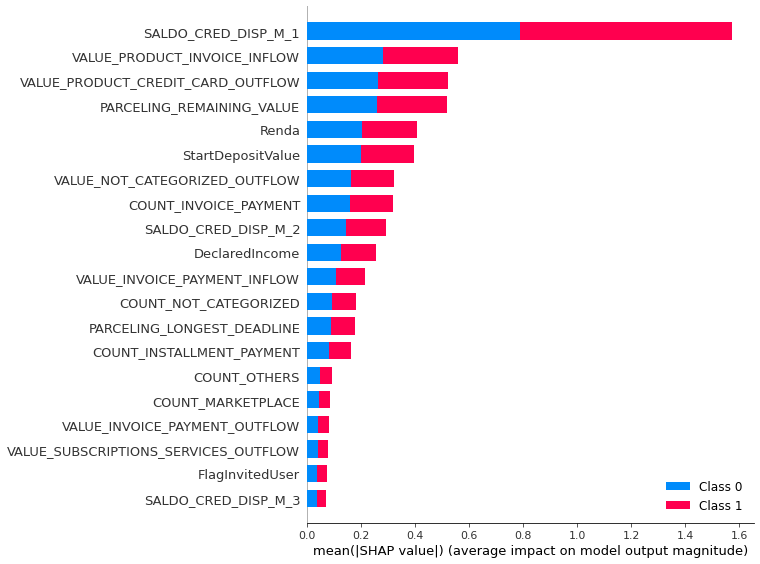

In [65]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

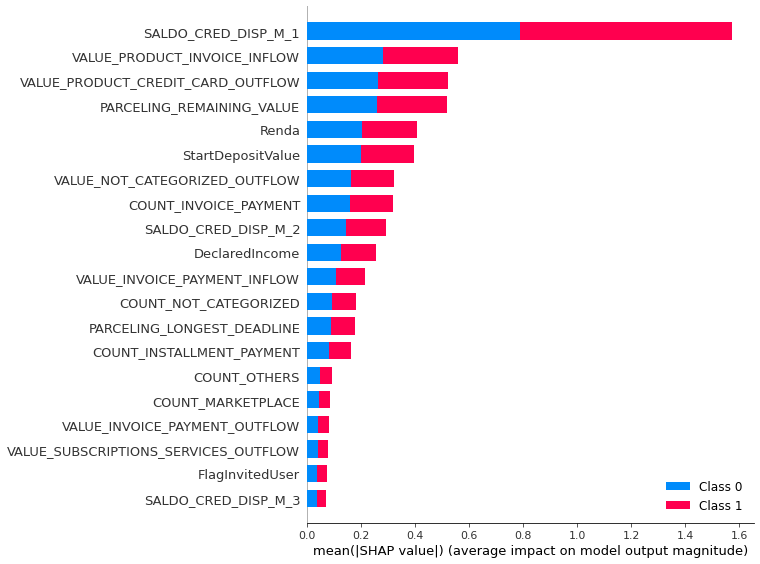

In [66]:
shap.summary_plot(shap_values, X_test)

In [67]:
def train_lightgbm(X,y,params, valid_X, valid_y,NFOLDS):

    folds = StratifiedKFold(n_splits=NFOLDS, random_state=111, shuffle=True)
    columns = X.columns
    splits = folds.split(X, y)
    y_oof = np.zeros(X.shape[0])
    score = 0
    score2=0

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = columns
    
    
    for fold_n, (train_index, valid_index) in enumerate(splits):
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        dtrain = lgb.Dataset(X_train, label=y_train)
        dvalid = lgb.Dataset(X_valid, label=y_valid)

        clf = lgb.train(params, dtrain, 1000, valid_sets = [dtrain, dvalid], verbose_eval=30, early_stopping_rounds=20)
        
        feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
        
        y_pred_valid = clf.predict(X_valid)
        y_oof[valid_index] = y_pred_valid
        print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
        score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
        score2 += roc_auc_score(valid_y, clf.predict(valid_X)) / NFOLDS
        del X_train, X_valid, y_train, y_valid
        gc.collect()

    print(f"\nMean AUC - OOT = {round(score2,5)}")
    print(f"\nMean AUC = {round(score,5)}")
    print(f"Out of folds AUC = {round(roc_auc_score(y, y_oof),5)}")
    
    return clf, pd.DataFrame({'Churn':y.iloc[:,0],'pred':y_oof})

In [68]:
target_ = ['Paid_max']
X1 = (train_x)
#X1 = (df.drop(target_+['Id_order_','ClientID_','ClientID','ClientId'],1))
'''
X1.rename(columns={'LAST_%_USAGE_CREDIT_max':'%_USADO_DO_LIMITE_NA_FATURA_ATRASADA',
                   'TotalPayedValue_sum':'SOMATORIA_VALOR_FATURAS_PASSADAS_PAGAS',
                   'FlagRegularPayment_mean':'%_FATURAS_PAGAS_EM_DIA',
                   'DaysPastDue_max':'MAXIMO_DIAS_FATURA_ATRASADA',
                   'DaysPastDue_std':'DESVP_DIAS_FATURA_ATRASADA',
                  'VALUE_PRODUCT_CREDIT_CARD_OUTFLOW':'VALOR_MEDIO_MES_GASTO_CREDITO',
                  'CountPayments_mean':'PAGAMENTOS_DE_FATURAS_REALIZADAS',
                  '%_USAGE_CREDIT_max':'%_MAXIMO_CREDITO_UTILIZADO'}, inplace=True)
'''
y1 = train_y

params = {
        'metric' : 'auc',
        'boosting_type' : 'gbdt',
        'colsample_bytree' : 0.8,
        'num_leaves' : 15,
        'max_depth' : -1,
        'n_estimators' : 1000,
        'min_data_in_leaf':80, 
        'reg_alpha': 20,
        'reg_lambda': 20,
        #'is_unbalance':True
        #'objective':'binary',
        #'learning_rate':0.1
    }

lgbm_example, pred_lgbm = train_lightgbm(X1,y1,params,valid_x,valid_y,5)

NameError: name 'train_x' is not defined

In [ ]:
shap.summary_plot(shap_values, X_test)